In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='../DATA', train=True, download=True, transform=transform)

Files already downloaded and verified


In [4]:
test_data = datasets.CIFAR10(root='../DATA', train=False, download=True, transform=transform)

Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../DATA
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../DATA
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
for image,labels in train_loader:
    break

In [9]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [    5     4     0     9     1     2     2     4     2     2]
Class:    dog  deer plane truck   car  bird  bird  deer  bird  bird


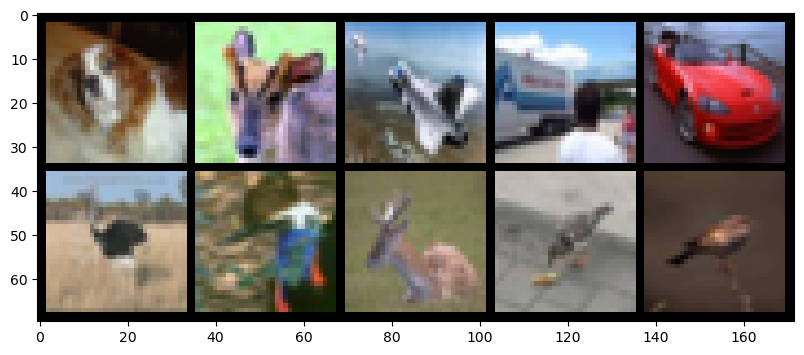

In [10]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        
        self.fc1 = nn.Linear(32*6*6, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)
        
        X = X.view(-1, 32*6*6)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [12]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.53660333  accuracy:  27.340%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.68793941  accuracy:  34.065%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.64369643  accuracy:  37.630%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.11749864  accuracy:  40.358%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.13650239  accuracy:  42.688%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.79455733  accuracy:  55.440%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.30922174  accuracy:  56.130%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.48415923  accuracy:  56.820%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.62856126  accuracy:  57.498%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.41258693  accuracy:  58.040%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 0.97493857  accuracy:  64.250%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.07760835  accuracy:  64.185%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.72306192  accuracy:  64.013%
epoch:  2  b

W is the input volume - in your case 128
K is the Kernel size - in your case 5
P is the padding - in your case 0 i believe
S is the stride - which you have not provided.

Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)

In [ ]:
(32 - 3)/1+1

In [ ]:
images[0].shape

(32-2) - loosing border information

(32 - 2)/2 - pooling layer

((32 - 2)/2) - 2 - another convolution

(((32 - 2)/2) - 2) / 2 - pooling layer

In [ ]:
(((32 - 2)/2) - 2) / 2 

In [ ]:
(((((32 - 2)/2) - 2) / 2 ) - 2 ) / 2

In [ ]:
((((32 - 2) - 2) / 2 ) -2 ) / 2

In [ ]:
(((32 -2) -2) -2) / 2